Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 37376498.96it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1158594.54it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 9489292.68it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3228903.18it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



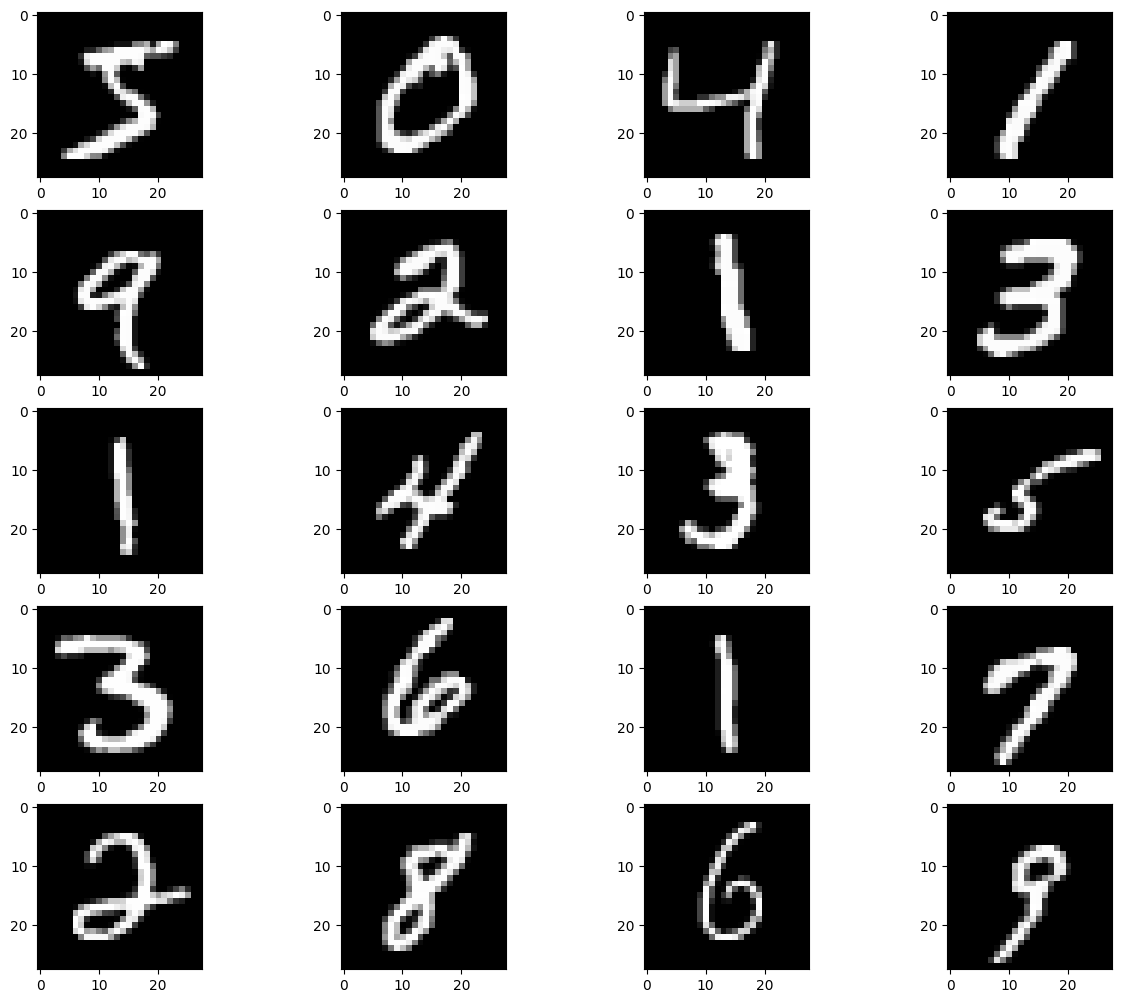

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST


def show_images(datset, num_samples=20, cols=4):
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0], cmap='gray')


data = MNIST(root="./dataset", download=True)
show_images(data)

In [2]:
import torch.nn.functional as F


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)


def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(
        sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
        + sqrt_one_minus_alphas_cumprod_t.to(device) * \
        noise.to(device), noise.to(device)


T = 300
betas = linear_beta_schedule(timesteps=T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [16]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 128


def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
    data_transform = transforms.Compose(data_transforms)

    train = MNIST(root="./dataset", download=True,
                  transform=data_transform)

    return train


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    # print(image.shape)


    if len(image.shape) == 4:
        # print(image.shape)
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image), cmap='gray')


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE,
                        shuffle=True, drop_last=True)

<ipython-input-17-14194e7e0cec>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


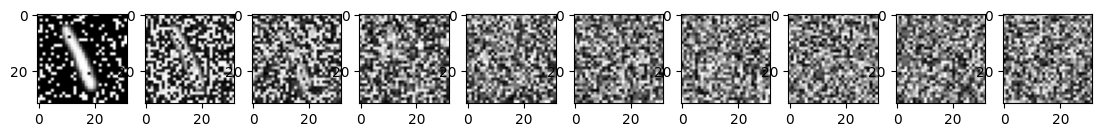

In [17]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15, 15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [18]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        # print("h before",h.shape)

        time_emb = self.relu(self.time_mlp(t))
        # print(time_emb.shape)
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # print("h",h.shape)
        h = self.bnorm2(self.relu(self.conv2(h)))
        # print("h final",h.shape)
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(
            half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (32, 64, 128, 256, 512)
        up_channels = (512, 256, 128, 64, 32)
        out_dim = 1
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1],
                                    time_emb_dim)
                                    for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True)
                                  for i in range(len(up_channels)-1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        # Initial conv
        # print("x", x.shape)

        x = self.conv0(x)
        # Unet
        # print("x1",x.shape)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        # print("unet",self.output(x).shape)
        return self.output(x)


model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  15639169


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=64, bias=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2

In [19]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [20]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    #(current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise



@torch.no_grad()
def sample_plot_image(IMG,tRand=None):
    img_size = IMG_SIZE
    img = IMG
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, num_images-int(i/stepsize))
            show_tensor_image(img.detach().cpu())
    plt.show()

Epoch 0 | step 000 Loss: 0.7481812834739685 


<ipython-input-20-877db0117c1a>:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, num_images-int(i/stepsize))


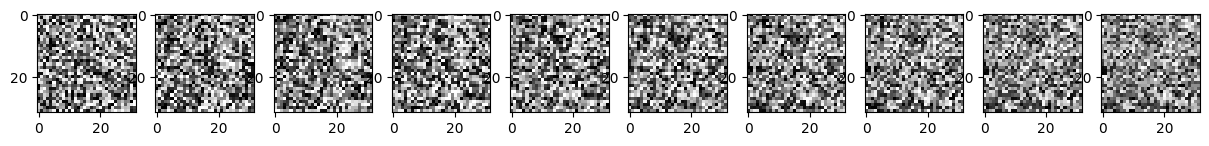

Epoch 1 | step 000 Loss: 0.1139301285147667 


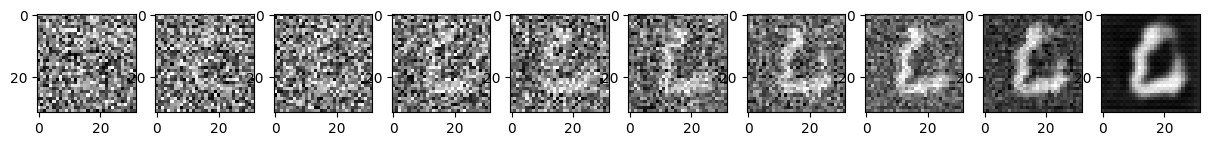

Epoch 2 | step 000 Loss: 0.1081680953502655 


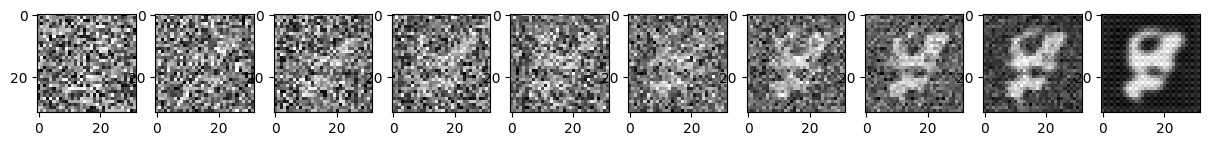

Epoch 3 | step 000 Loss: 0.09626234322786331 


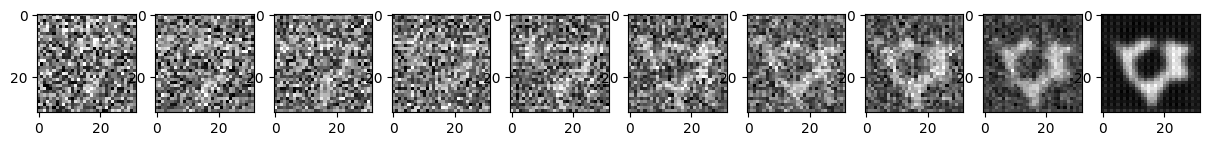

Epoch 4 | step 000 Loss: 0.0954926460981369 


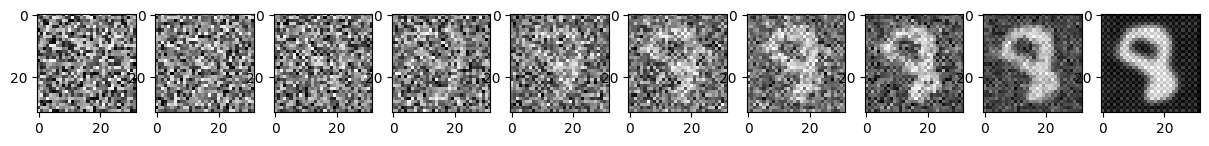

Epoch 5 | step 000 Loss: 0.09405525773763657 


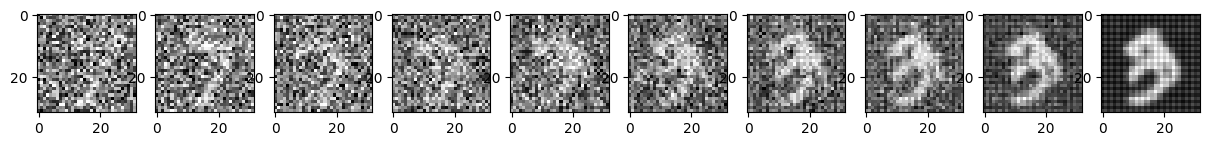

Epoch 6 | step 000 Loss: 0.08505010604858398 


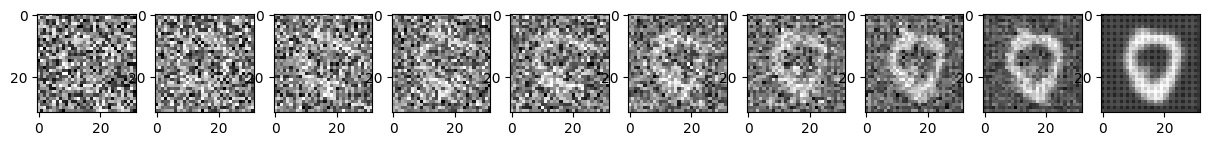

Epoch 7 | step 000 Loss: 0.09987188130617142 


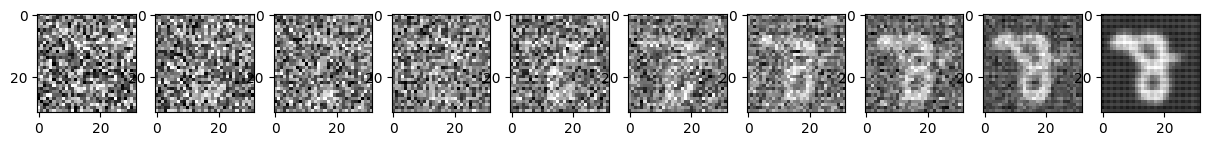

Epoch 8 | step 000 Loss: 0.08544079214334488 


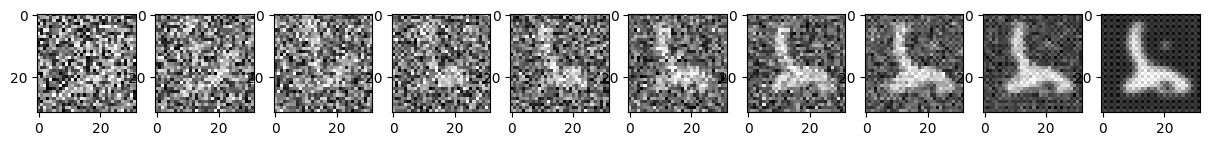

Epoch 9 | step 000 Loss: 0.08793258666992188 


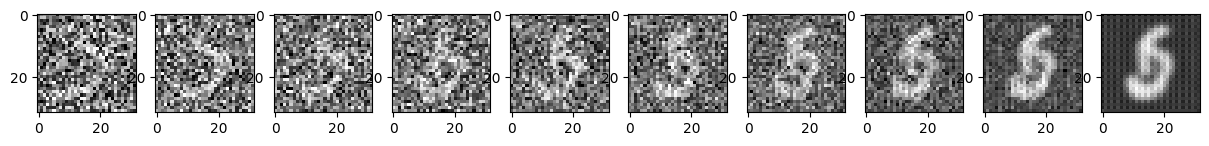

Epoch 10 | step 000 Loss: 0.07933524250984192 


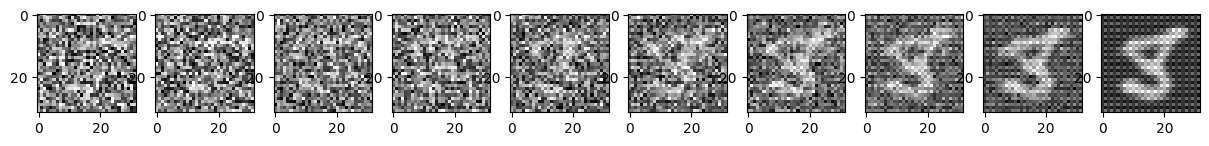

Epoch 11 | step 000 Loss: 0.08492190390825272 


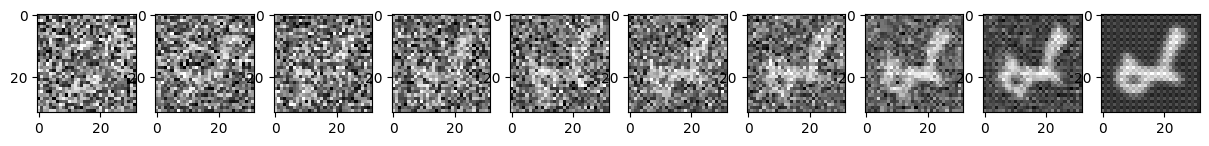

Epoch 12 | step 000 Loss: 0.07759781181812286 


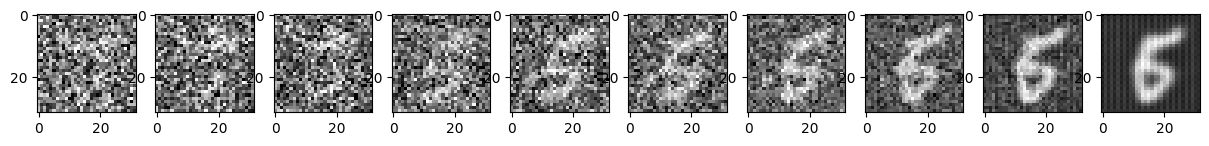

Epoch 13 | step 000 Loss: 0.08922712504863739 


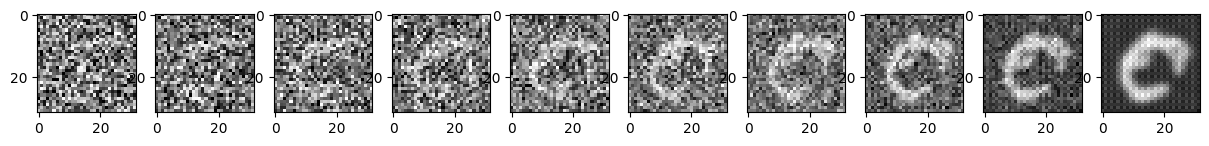

Epoch 14 | step 000 Loss: 0.0741722583770752 


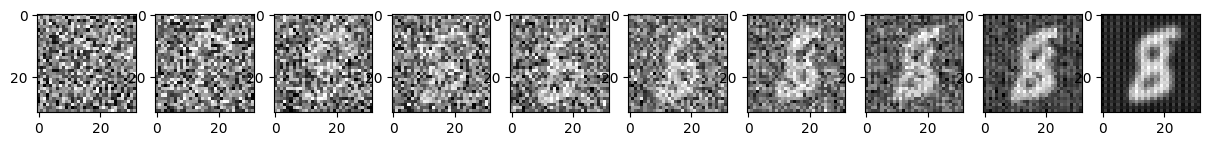

Epoch 15 | step 000 Loss: 0.08092562854290009 


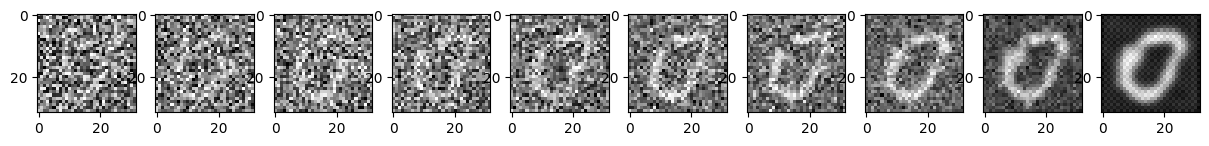

Epoch 16 | step 000 Loss: 0.07503914833068848 


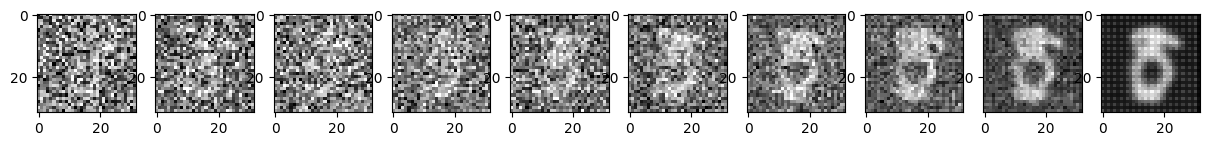

Epoch 17 | step 000 Loss: 0.07478702068328857 


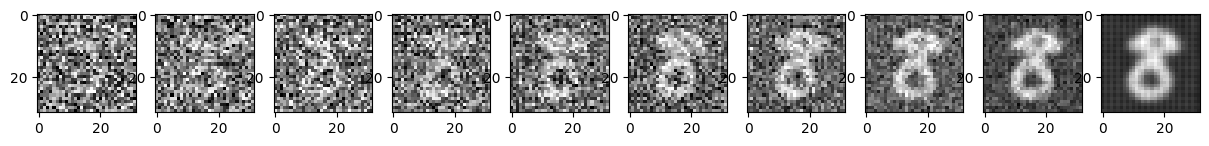

Epoch 18 | step 000 Loss: 0.07729198038578033 


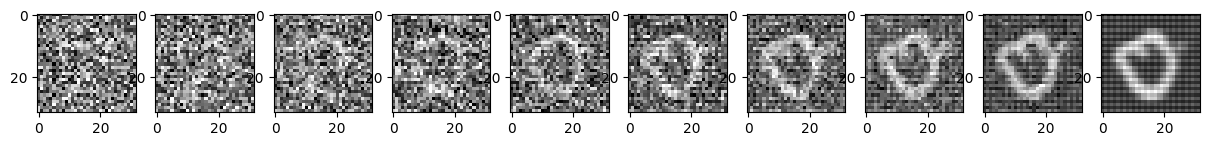

Epoch 19 | step 000 Loss: 0.07646296918392181 


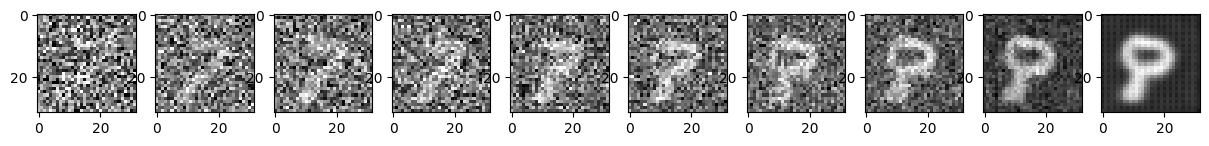

Epoch 20 | step 000 Loss: 0.07749312371015549 


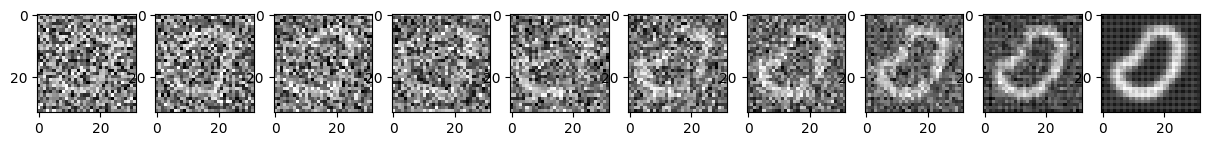

Epoch 21 | step 000 Loss: 0.077765092253685 


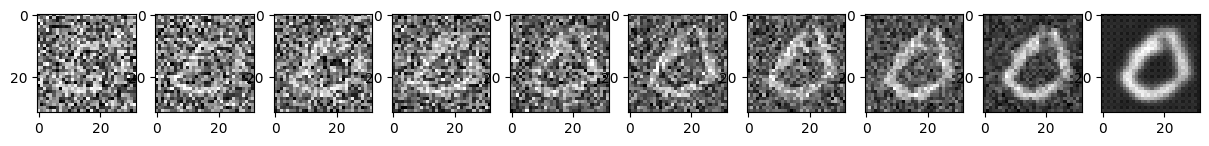

Epoch 22 | step 000 Loss: 0.07770290970802307 


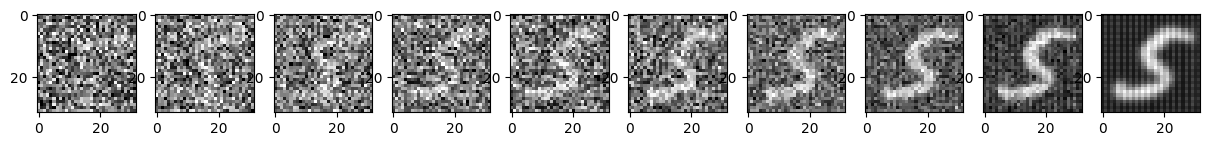

Epoch 23 | step 000 Loss: 0.0784769207239151 


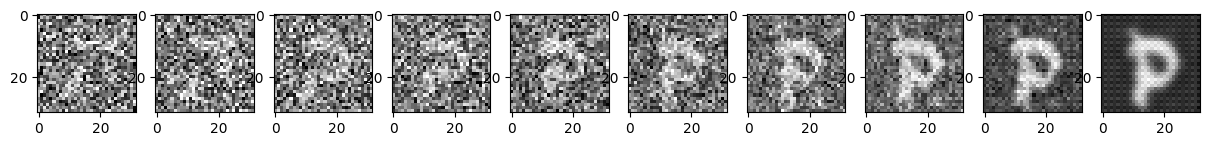

Epoch 24 | step 000 Loss: 0.0713619738817215 


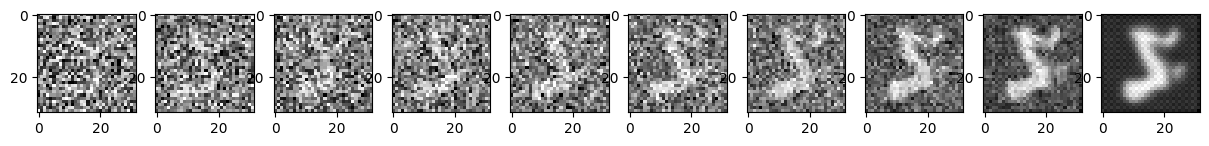

Epoch 25 | step 000 Loss: 0.07603380084037781 


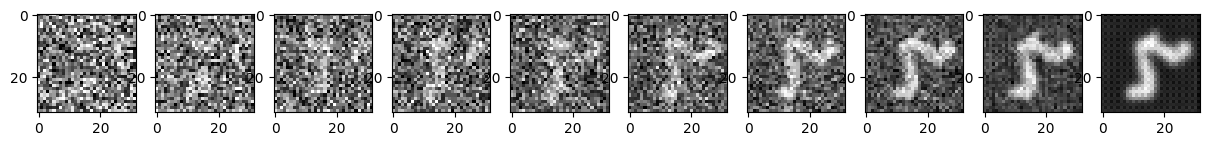

Epoch 26 | step 000 Loss: 0.07563549280166626 


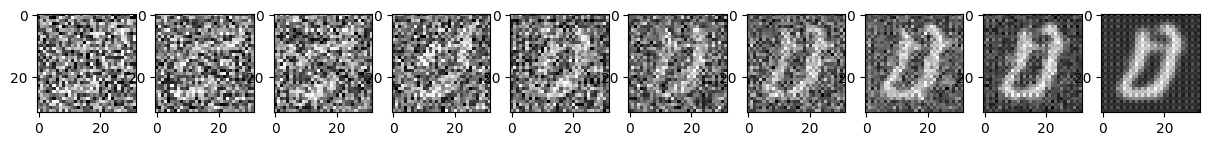

Epoch 27 | step 000 Loss: 0.07833616435527802 


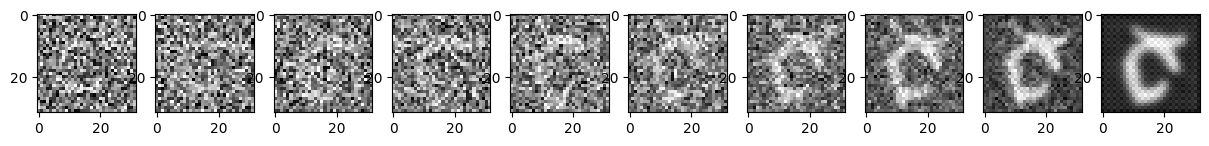

Epoch 28 | step 000 Loss: 0.0767097994685173 


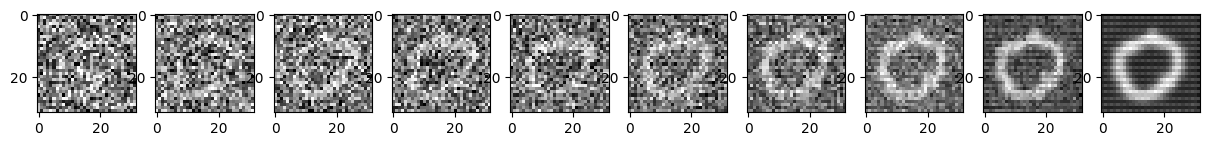

Epoch 29 | step 000 Loss: 0.07125537097454071 


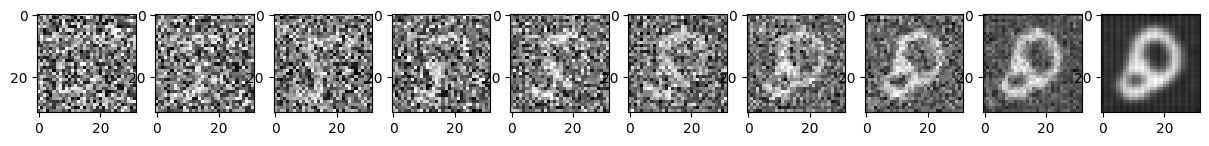

Epoch 30 | step 000 Loss: 0.07612982392311096 


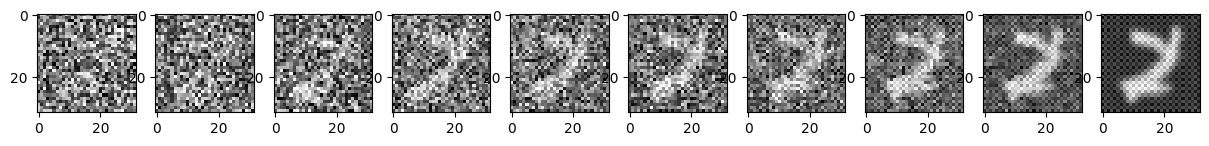

Epoch 31 | step 000 Loss: 0.0804726853966713 


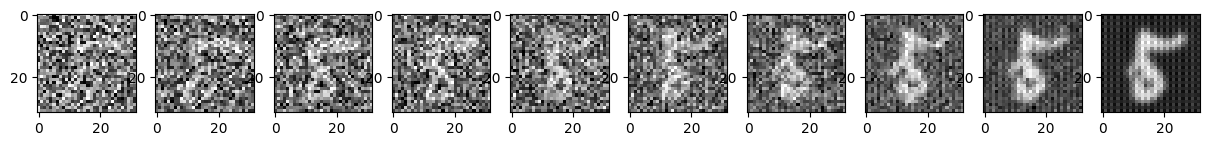

Epoch 32 | step 000 Loss: 0.07257657498121262 


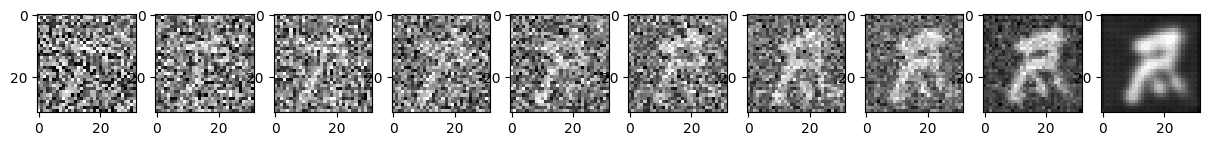

Epoch 33 | step 000 Loss: 0.07675708830356598 


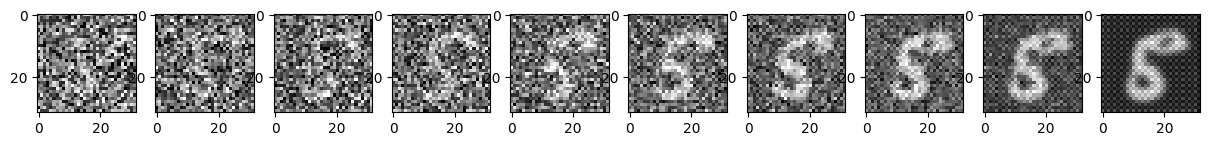

Epoch 34 | step 000 Loss: 0.07696180790662766 


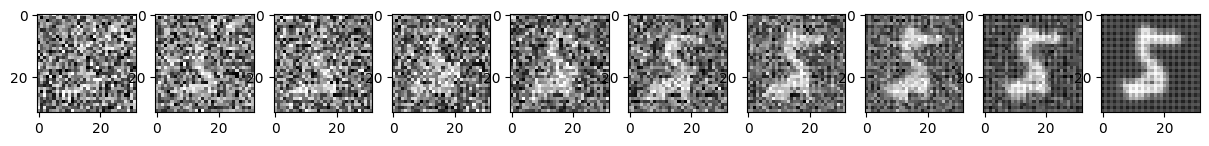

Epoch 35 | step 000 Loss: 0.0676778256893158 


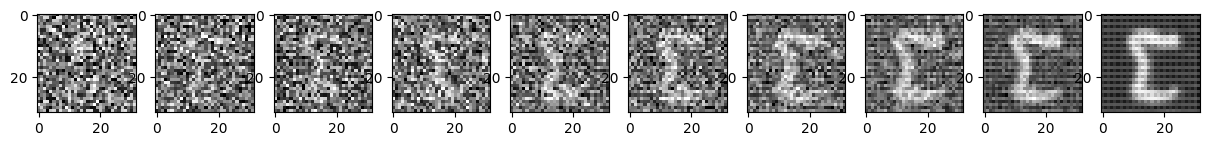

Epoch 36 | step 000 Loss: 0.07903487980365753 


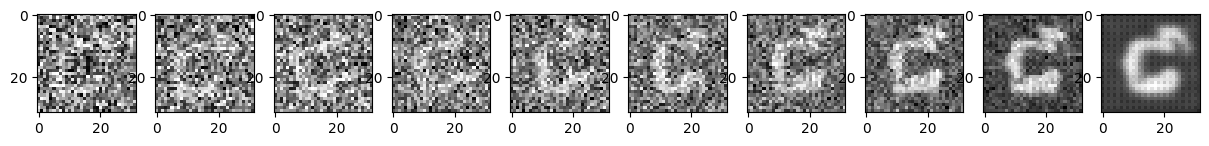

Epoch 37 | step 000 Loss: 0.070863276720047 


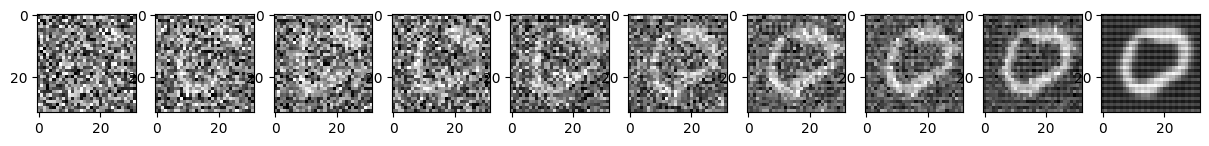

Epoch 38 | step 000 Loss: 0.0714997947216034 


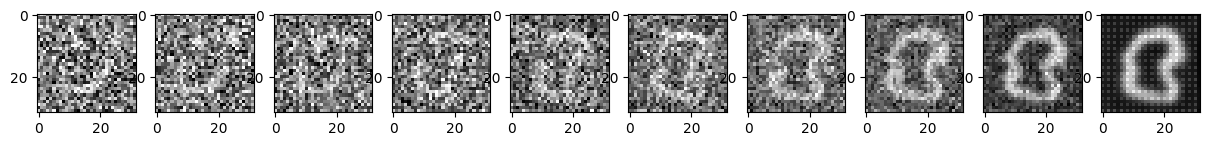

Epoch 39 | step 000 Loss: 0.07474632561206818 


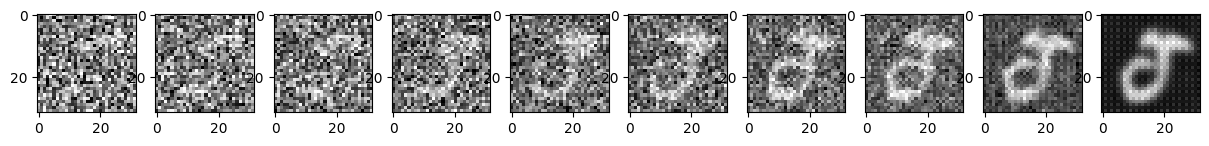

Epoch 40 | step 000 Loss: 0.07105444371700287 


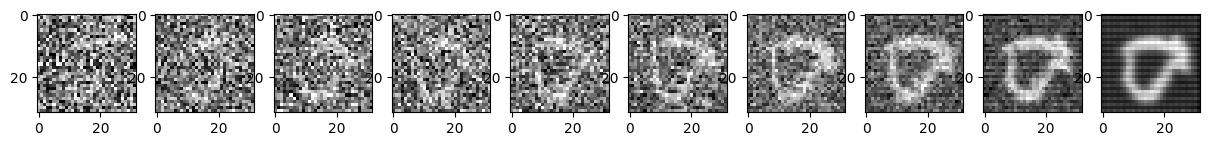

Epoch 41 | step 000 Loss: 0.06828451156616211 


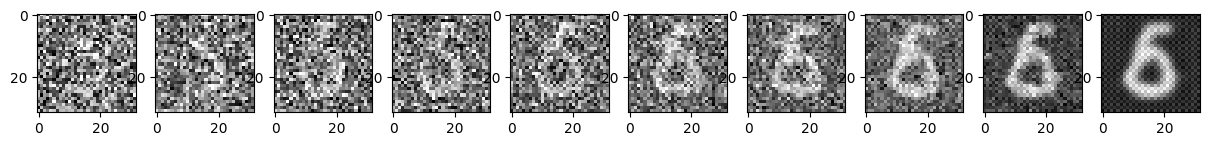

Epoch 42 | step 000 Loss: 0.07574745267629623 


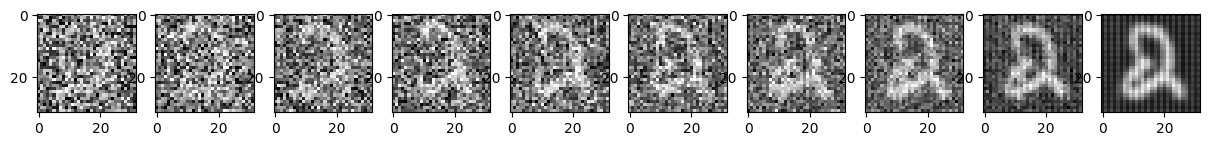

Epoch 43 | step 000 Loss: 0.07587695121765137 


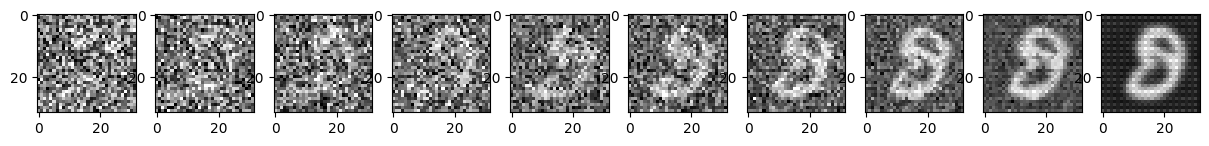

Epoch 44 | step 000 Loss: 0.0753912627696991 


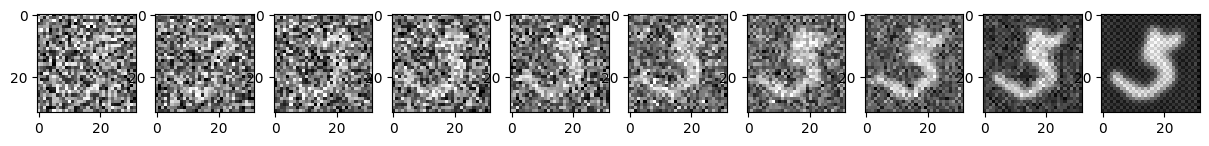

Epoch 45 | step 000 Loss: 0.07506802678108215 


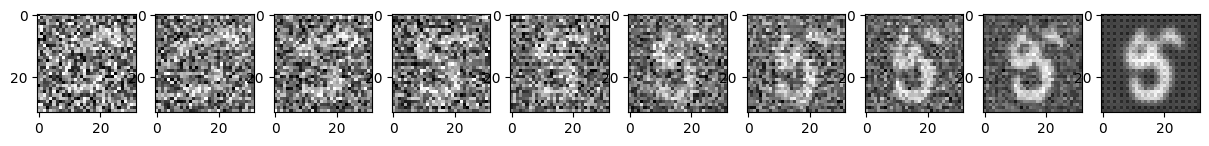

Epoch 46 | step 000 Loss: 0.07590300589799881 


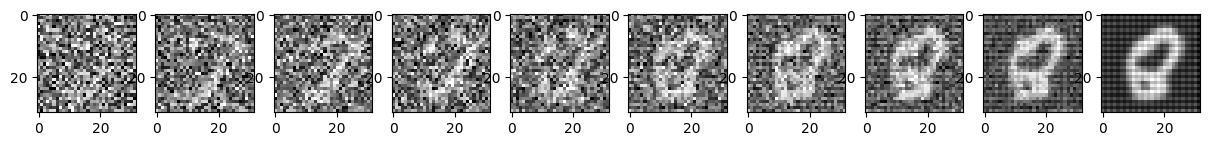

Epoch 47 | step 000 Loss: 0.07576222717761993 


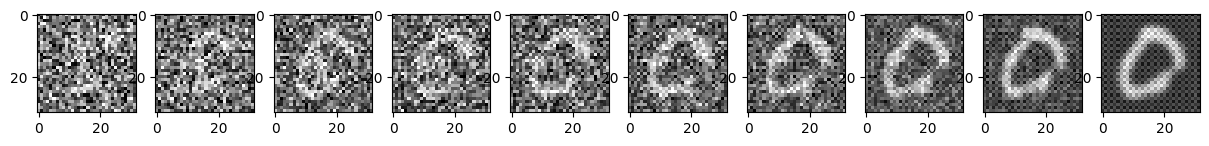

Epoch 48 | step 000 Loss: 0.07300225645303726 


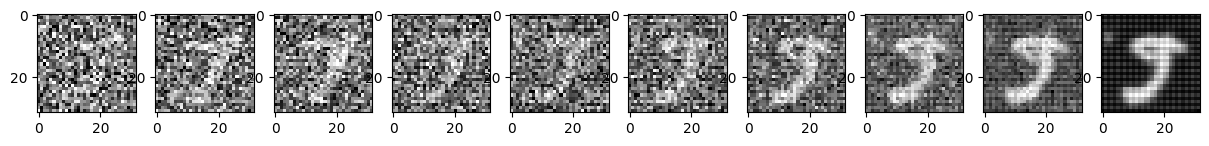

Epoch 49 | step 000 Loss: 0.07274229824542999 


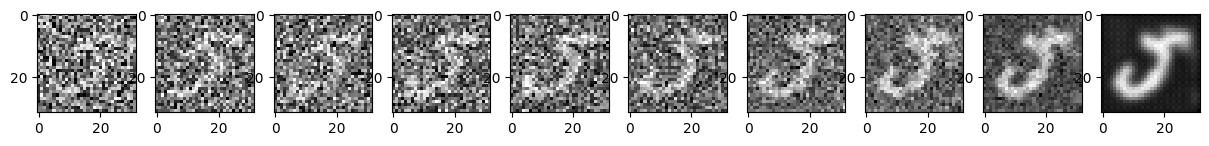

Epoch 50 | step 000 Loss: 0.07529419660568237 


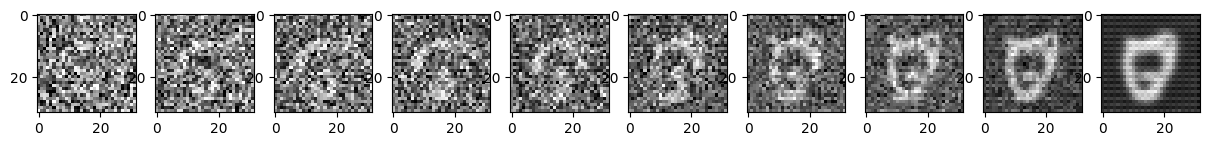

Epoch 51 | step 000 Loss: 0.07523371279239655 


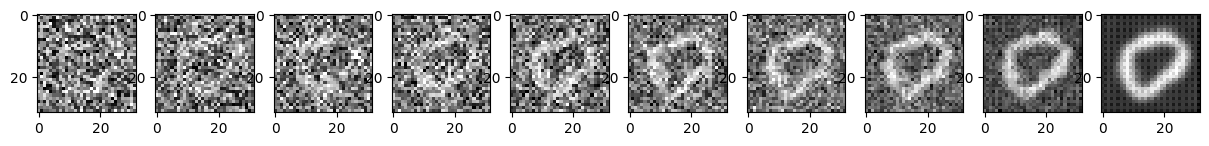

Epoch 52 | step 000 Loss: 0.07698139548301697 


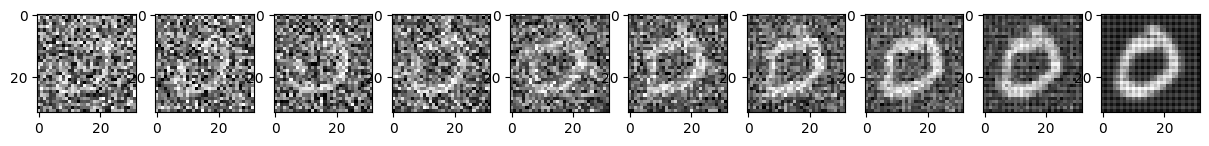

Epoch 53 | step 000 Loss: 0.06876690685749054 


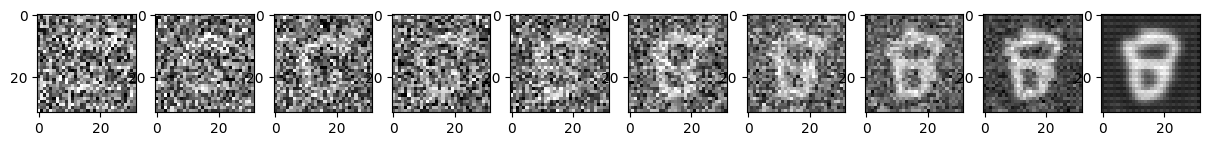

Epoch 54 | step 000 Loss: 0.06783529371023178 


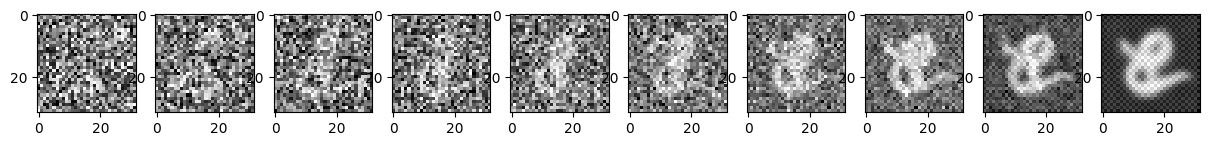

Epoch 55 | step 000 Loss: 0.07153941690921783 


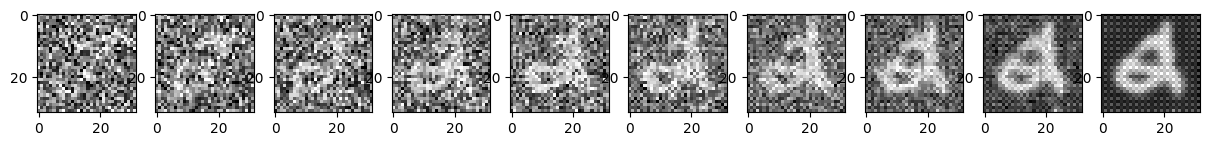

Epoch 56 | step 000 Loss: 0.06975774466991425 


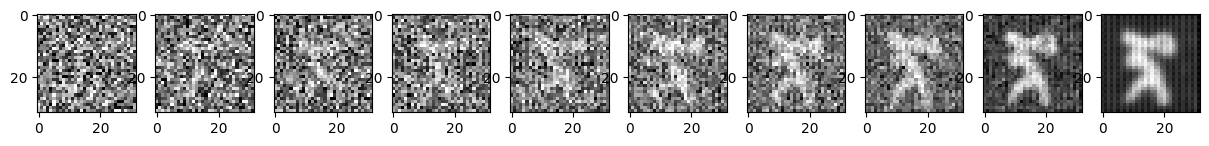

Epoch 57 | step 000 Loss: 0.06858178973197937 


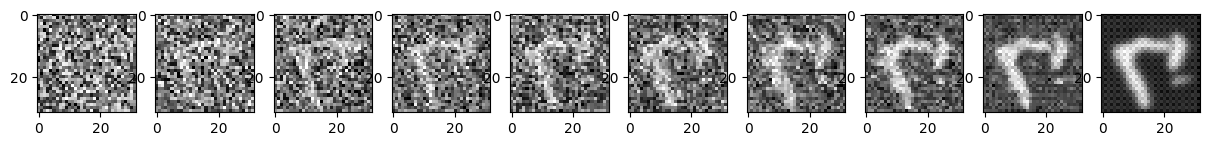

Epoch 58 | step 000 Loss: 0.07242390513420105 


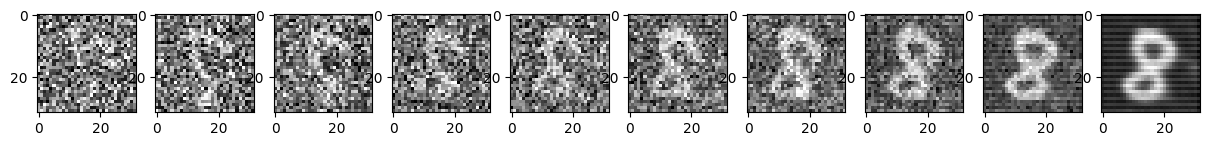

Epoch 59 | step 000 Loss: 0.07147341966629028 


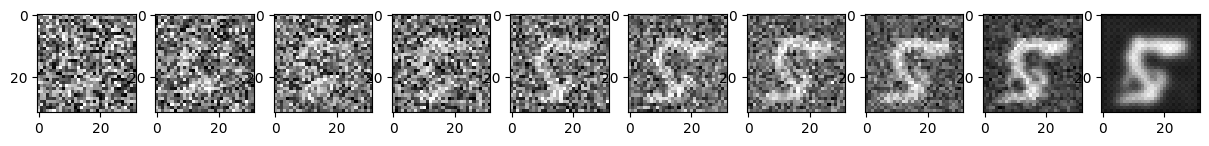

Epoch 60 | step 000 Loss: 0.07144400477409363 


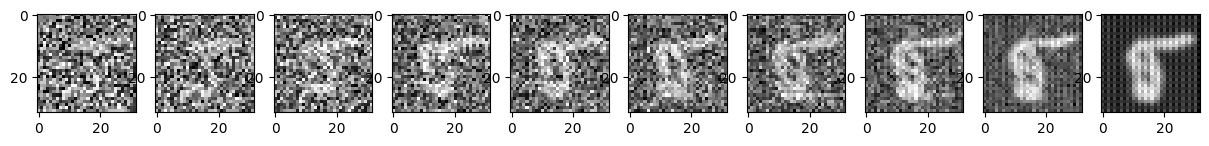

Epoch 61 | step 000 Loss: 0.0712721049785614 


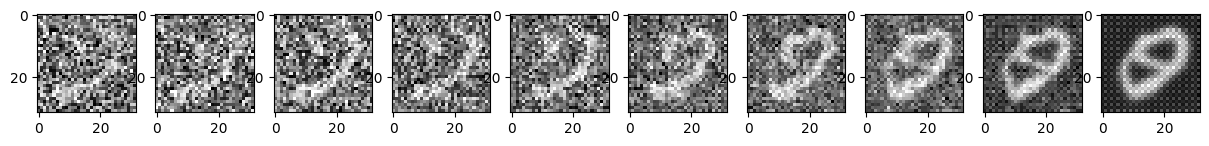

Epoch 62 | step 000 Loss: 0.07205573469400406 


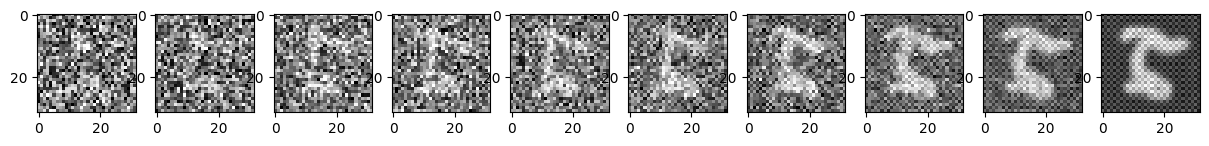

Epoch 63 | step 000 Loss: 0.07043150067329407 


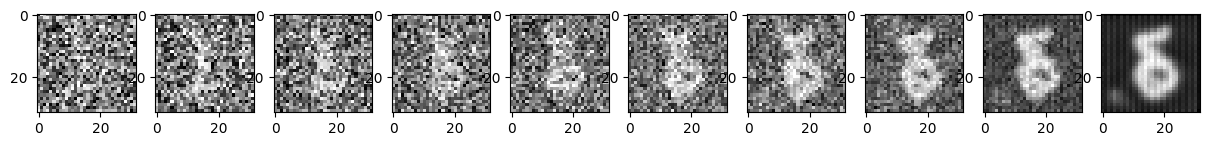

Epoch 64 | step 000 Loss: 0.07544340193271637 


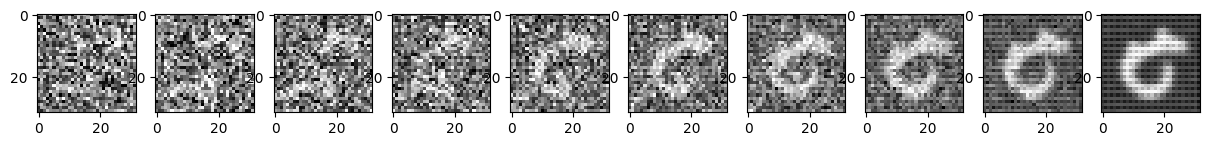

Epoch 65 | step 000 Loss: 0.07203957438468933 


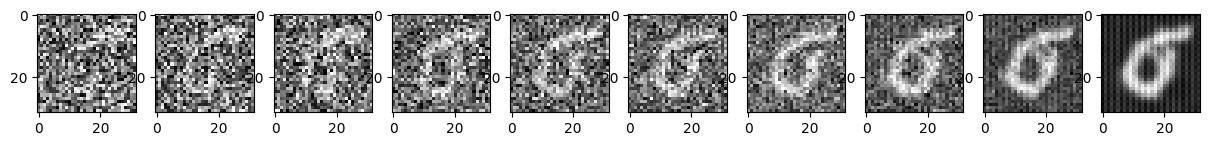

Epoch 66 | step 000 Loss: 0.07067888230085373 


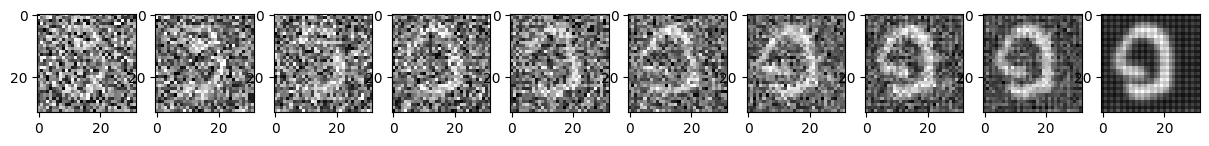

Epoch 67 | step 000 Loss: 0.07205548137426376 


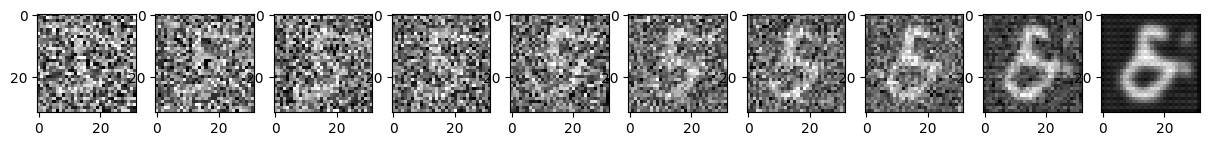

Epoch 68 | step 000 Loss: 0.07391662895679474 


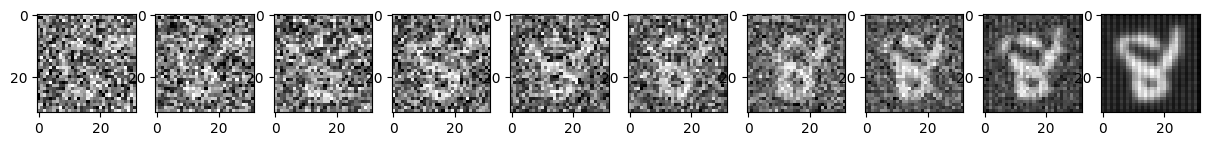

Epoch 69 | step 000 Loss: 0.06899762153625488 


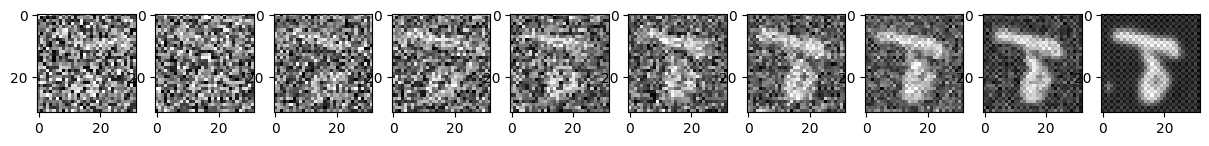

Epoch 70 | step 000 Loss: 0.08775097131729126 


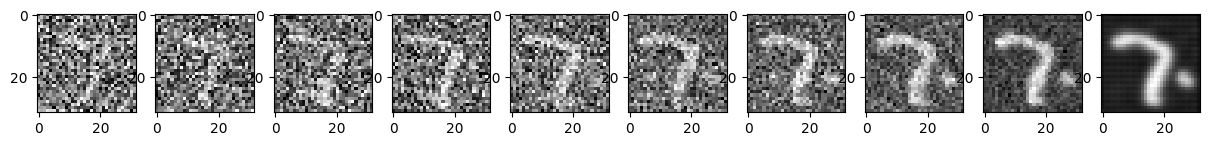

Epoch 71 | step 000 Loss: 0.06621255725622177 


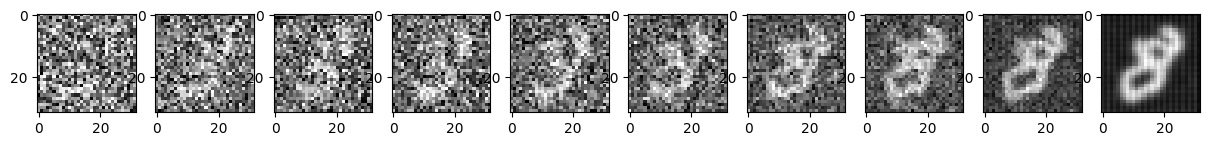

Epoch 72 | step 000 Loss: 0.07320104539394379 


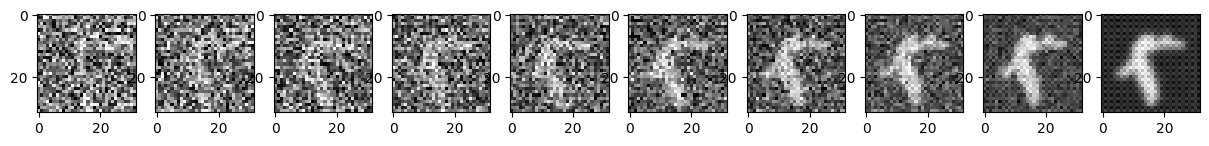

Epoch 73 | step 000 Loss: 0.06772512197494507 


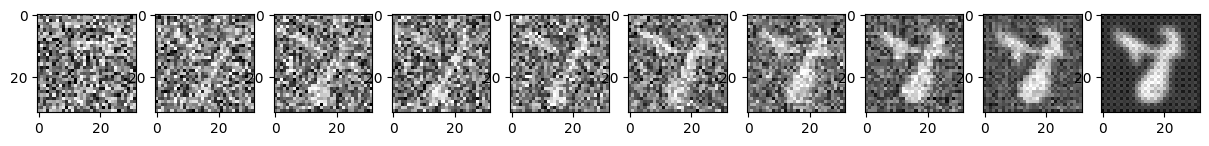

Epoch 74 | step 000 Loss: 0.07321080565452576 


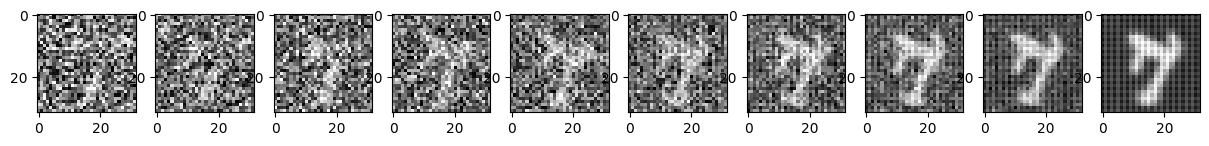

Epoch 75 | step 000 Loss: 0.06483771651983261 


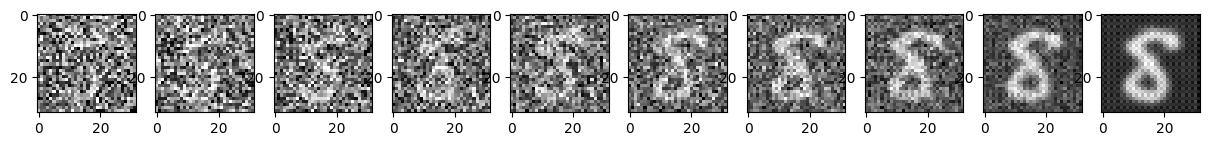

Epoch 76 | step 000 Loss: 0.06514401733875275 


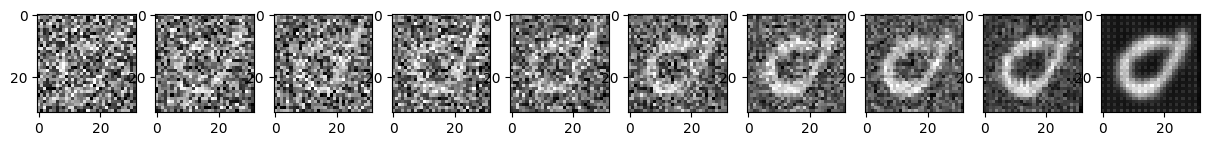

Epoch 77 | step 000 Loss: 0.07232436537742615 


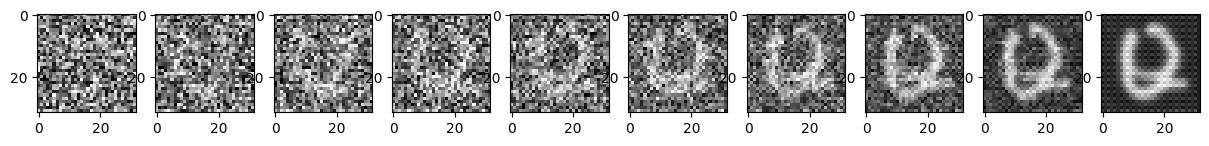

Epoch 78 | step 000 Loss: 0.07089920341968536 


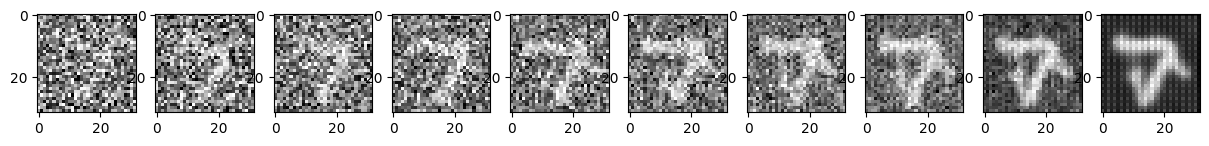

Epoch 79 | step 000 Loss: 0.07036248594522476 


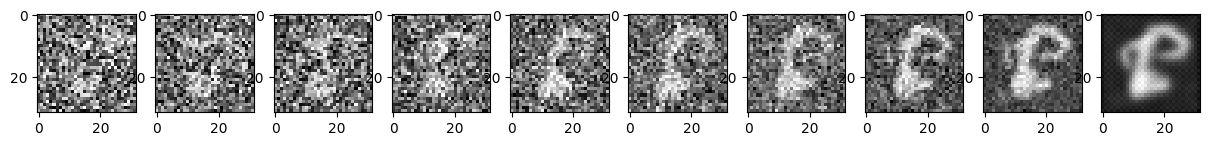

Epoch 80 | step 000 Loss: 0.07158635556697845 


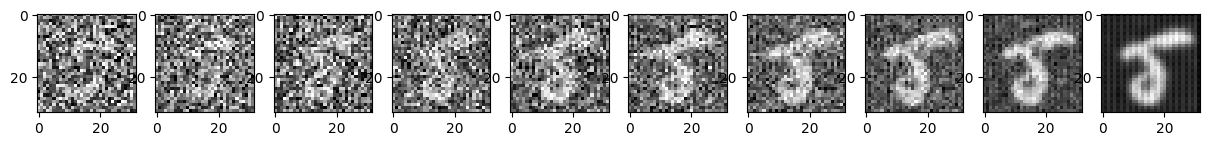

Epoch 81 | step 000 Loss: 0.07250306010246277 


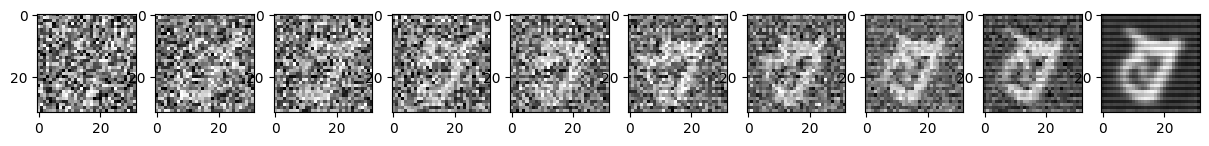

Epoch 82 | step 000 Loss: 0.07256485521793365 


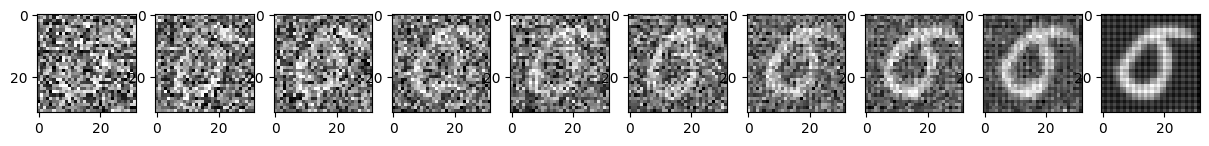

Epoch 83 | step 000 Loss: 0.0689597874879837 


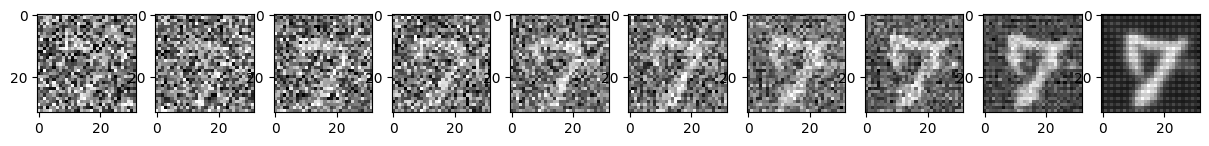

Epoch 84 | step 000 Loss: 0.06960499286651611 


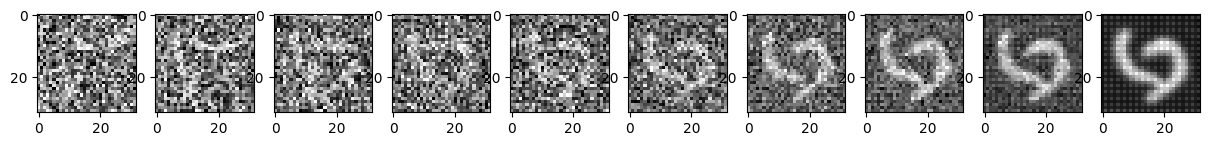

Epoch 85 | step 000 Loss: 0.06629282981157303 


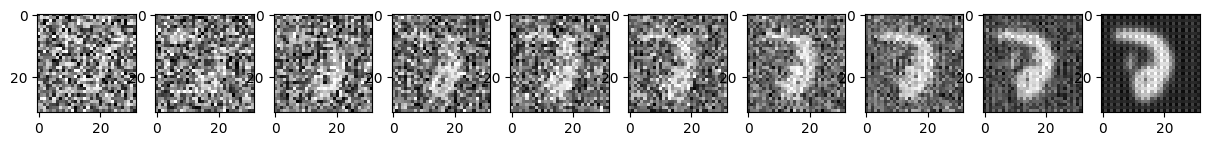

Epoch 86 | step 000 Loss: 0.0731097012758255 


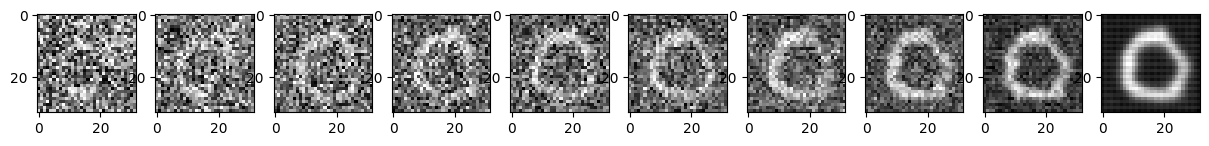

Epoch 87 | step 000 Loss: 0.07521387934684753 


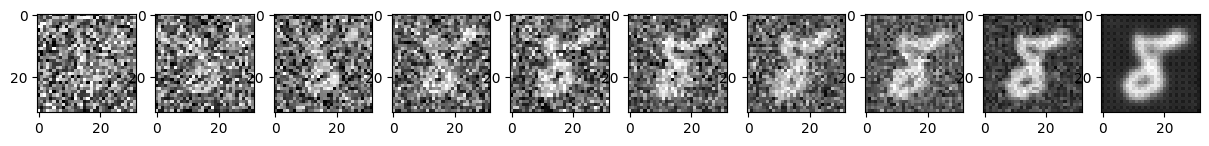

Epoch 88 | step 000 Loss: 0.06881417334079742 


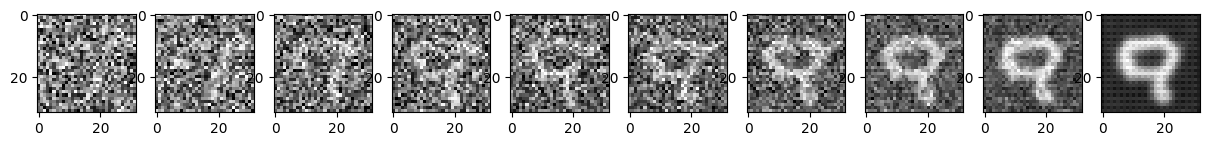

Epoch 89 | step 000 Loss: 0.06919015944004059 


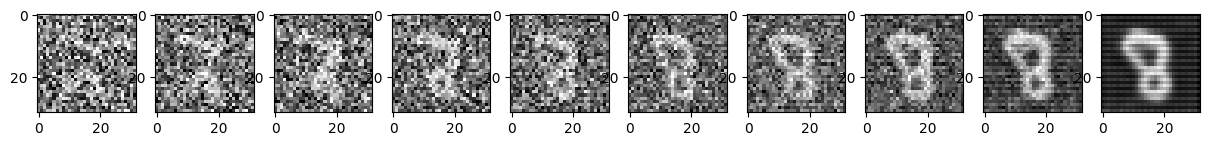

Epoch 90 | step 000 Loss: 0.06677643954753876 


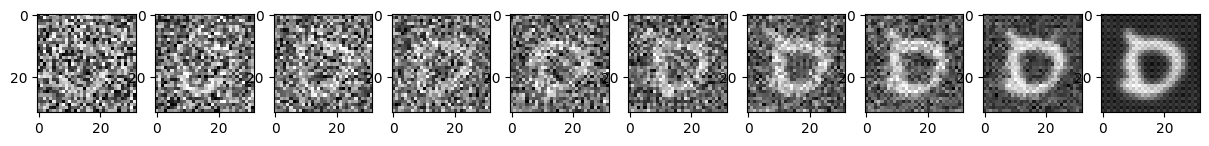

Epoch 91 | step 000 Loss: 0.07438626140356064 


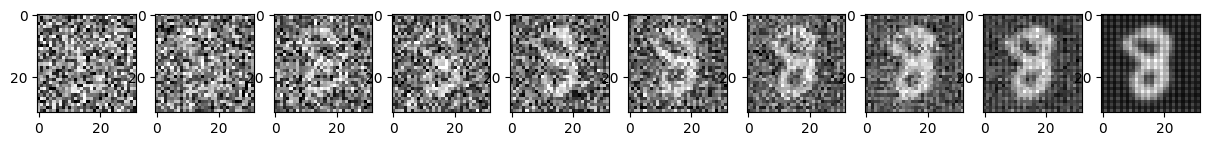

Epoch 92 | step 000 Loss: 0.0655118003487587 


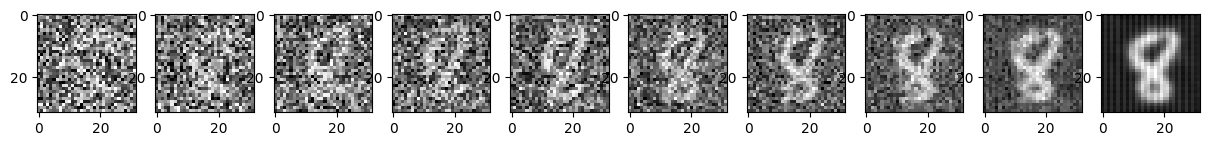

Epoch 93 | step 000 Loss: 0.07612936198711395 


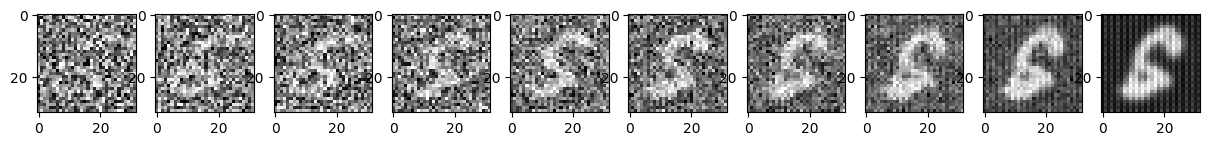

Epoch 94 | step 000 Loss: 0.0708765834569931 


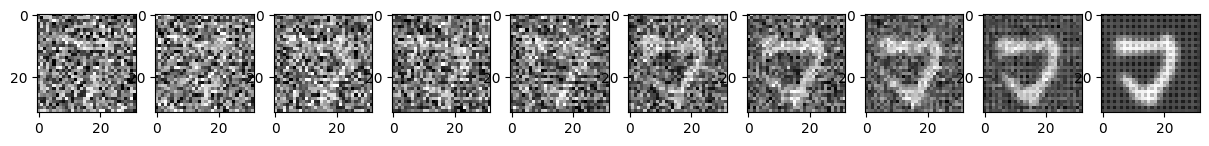

Epoch 95 | step 000 Loss: 0.06494821608066559 


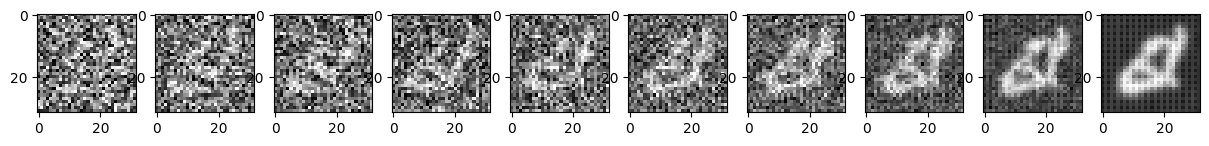

Epoch 96 | step 000 Loss: 0.06981658935546875 


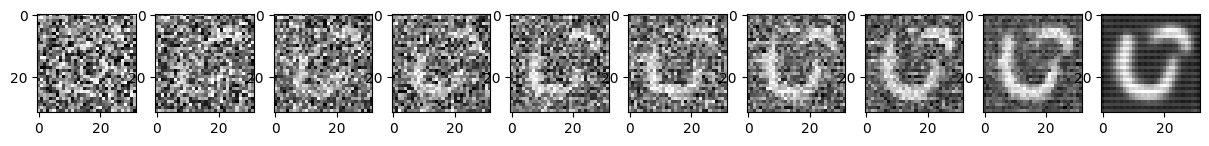

Epoch 97 | step 000 Loss: 0.06845925748348236 


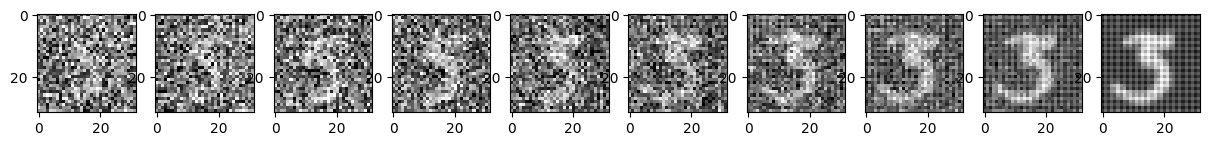

Epoch 98 | step 000 Loss: 0.06800812482833862 


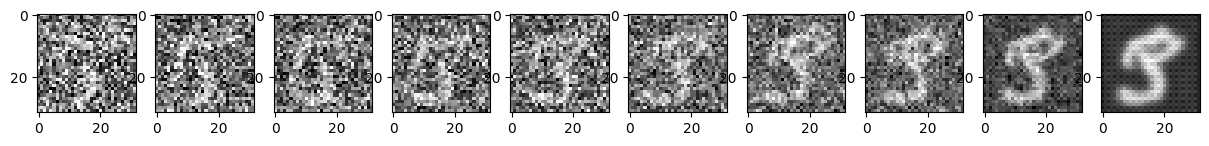

Epoch 99 | step 000 Loss: 0.0715203583240509 


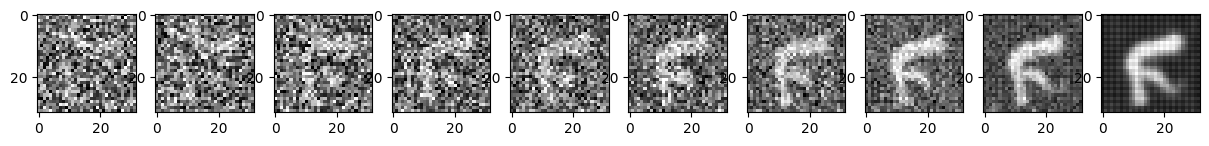

In [25]:
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
IMG = torch.randn((1, 1, IMG_SIZE, IMG_SIZE), device=device)
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 1 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image(IMG)